In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from IPython.display import clear_output
import time
import torch
import torch.nn as nn
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:

# Configuration as a dictionary
config = {
    "nb_layers": 4,               # Number of convolutional layers
    "nb_out_filter": 32,           # Number of output filters for Conv2D
    "conv_ker_size": 3,            # Convolution kernel size
    "activation": "relu",          # Activation function: "relu" or "lrelu"
    "dropout_rate": 0.1,           # Dropout rate
    "regularization": 0.0001       # L2 regularization
}

class CNN(nn.Module):
    def __init__(self, nb_inputs, nb_outputs, config):
        super(CNN, self).__init__()
        
        layers = []
        in_channels = nb_inputs
        for _ in range(config['nb_layers']):
            layers.append(nn.Conv2d(in_channels, config['nb_out_filter'], kernel_size=config['conv_ker_size'], padding='same'))
            layers.append(nn.ReLU() if config['activation'] == "relu" else nn.LeakyReLU(0.01))
            layers.append(nn.Dropout(config['dropout_rate']))
            in_channels = config['nb_out_filter']

        # Output layer
        layers.append(nn.Conv2d(in_channels, nb_outputs, kernel_size=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
# Define the number of input channels (thk, slopsurfx, slopsurfy) and output channels (ubar, vbar)
nb_inputs = 3  # thk, slopsurfx, slopsurfy
nb_outputs = 2  # ubar, vbar

# Instantiate the CNN model

model = CNN(nb_inputs, nb_outputs, config).to(device)
model.load_state_dict(torch.load('/home/klleshi/IGEM/InvertedGlacierEvolutionModel/glacier_flow_model.pth'))
model.eval()

/tmp/ipykernel_52785/1707888346.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/klleshi/IGEM/InvertedGlacierEvolutionModel/glaci

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [4]:
# Define PyTorch version of compute_divflux
def compute_divflux(u, v, h, dx, dy):
    """
    Upwind computation of the divergence of the flux: d(u h)/dx + d(v h)/dy.
    """
    # Compute u and v on the staggered grid
    u = torch.cat([u[:, :1], 0.5 * (u[:, :-1] + u[:, 1:]), u[:, -1:]], dim=1)  # shape (ny, nx+1)
    v = torch.cat([v[:1, :], 0.5 * (v[:-1, :] + v[1:, :]), v[-1:, :]], dim=0)  # shape (ny+1, nx)

    # Extend h with constant value at the domain boundaries
    Hx = torch.nn.functional.pad(h, (1, 1, 0, 0), mode="constant")  # shape (ny, nx+2)
    Hy = torch.nn.functional.pad(h, (0, 0, 1, 1), mode="constant")  # shape (ny+2, nx)

    # Compute fluxes by selecting the upwind quantities
    Qx = u * torch.where(u > 0, Hx[:, :-1], Hx[:, 1:])  # shape (ny, nx+1)
    Qy = v * torch.where(v > 0, Hy[:-1, :], Hy[1:, :])  # shape (ny+1, nx)

    # Compute the divergence, final shape is (ny, nx)
    divflux = (Qx[:, 1:] - Qx[:, :-1]) / dx + (Qy[1:, :] - Qy[:-1, :]) / dy
    return divflux


# Define PyTorch version of compute_gradient
def compute_gradient(s, dx, dy):
    """
    Compute spatial 2D gradient of a given field.
    """
    EX = torch.cat([1.5 * s[:, :1] - 0.5 * s[:, 1:2], 0.5 * (s[:, :-1] + s[:, 1:]), 1.5 * s[:, -1:] - 0.5 * s[:, -2:-1]], dim=1)
    diffx = (EX[:, 1:] - EX[:, :-1]) / dx

    EY = torch.cat([1.5 * s[:1, :] - 0.5 * s[1:2, :], 0.5 * (s[:-1, :] + s[1:, :]), 1.5 * s[-1:, :] - 0.5 * s[-2:-1, :]], dim=0)
    diffy = (EY[1:, :] - EY[:-1, :]) / dy

    return diffx, diffy


# Apply boundary condition in PyTorch
def apply_boundary_condition(H_ice, boundary_width=5):
    """
    Apply boundary condition to the ice thickness field `H_ice`.
    """
    ny, nx = H_ice.shape

    # Create linear ramps
    ramp = torch.linspace(1, 0, boundary_width, device=H_ice.device)

    # Apply boundary condition to the left and right boundaries
    H_ice[:, :boundary_width] *= ramp.flip(0)  # Left
    H_ice[:, -boundary_width:] *= ramp  # Right

    # Apply boundary condition to the top and bottom boundaries
    H_ice[:boundary_width, :] *= ramp.flip(0).unsqueeze(1)  # Top
    H_ice[-boundary_width:, :] *= ramp.unsqueeze(1)  # Bottom

    return H_ice
def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing


def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")




In [5]:
# Physical parameters
ttot = 700  # Time limit (yr)
grad_b = 0.001  # Mass balance gradient
b_max = 0.5  # Maximum precip (m/yr)
Z_ELA = 3000  # Elevation of equilibrium line altitude (m)

# Load the topography data
nc_file = netCDF4.Dataset('bedrock.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device, dtype=torch.float32)


# Scaling factors (assuming they were precomputed)
scaling_factors = {
    "thk": 780.0,  # Example values; replace with actual scaling factors
    "slopsurfx": 1.8200000524520874,
    "slopsurfy": 1.6096999645233154,
    "ubar": 346.2121276855469,
    "vbar": 173.1743927001953
}





In [6]:
def forward_simulation(Z_ELA, grad_b, b_max,Z_topo,ttot,scaling_factors,Lx = 49700,Ly = 32300,dx=100,dy=100,cfl = 0.20,dtmax = 1,device=device):

    # Physical parameters (unchanged)

    nx = int(Lx / dx)
    ny = int(Ly / dy)

    # Initialize ice thickness and surface
    H_ice = torch.zeros((ny, nx), device=device, dtype=torch.float32)
    Z_surf = Z_topo + H_ice
    
    # Compute initial gradients of surface elevation (slopes)
    slopsurfx, slopsurfy = compute_gradient(Z_surf, dx, dy)
    
    # Initialize time and iteration counter
    time = torch.tensor(0.0, device=device, dtype=torch.float32)
    dt = torch.tensor(dtmax, device=device, dtype=torch.float32)
    it = 0


    # Main simulation loop
    while time < ttot:
        time += dt
        it += 1

        # Scale the inputs with stored scaling factors
        H_ice_scaled = H_ice / scaling_factors["thk"]
        slopsurfx_scaled = slopsurfx / scaling_factors["slopsurfx"]
        slopsurfy_scaled = slopsurfy / scaling_factors["slopsurfy"]

        # Combine scaled inputs and add batch dimension
        input_data_scaled = torch.stack([H_ice_scaled, slopsurfx_scaled, slopsurfy_scaled], dim=-1).unsqueeze(0)

        # Use the trained model to predict ubar (x-velocity) and vbar (y-velocity)
        with torch.no_grad():
            ubar_vbar_pred = model(input_data_scaled.permute(0, 3, 1, 2))  # Change to (batch, channels, height, width)
            ubar = ubar_vbar_pred[0, 0, :, :] * scaling_factors["ubar"]  # x-component of velocity
            vbar = ubar_vbar_pred[0, 1, :, :] * scaling_factors["vbar"]  # y-component of velocity

        # Compute maximum velocity for CFL condition
        vel_max = max(ubar.abs().max().item(), vbar.abs().max().item())

        # Compute time step (CFL condition)
        dt = min(cfl * dx / vel_max, dtmax)

        # Update rule (diffusion): Compute the change in thickness (dH/dt)
        dHdt = -compute_divflux(ubar, vbar, H_ice, dx, dy)

        # Update ice thickness and ensure no negative values
        H_ice += dt * dHdt
        H_ice = torch.clamp(H_ice, min=0)

        # Define the SMB (Surface Mass Balance)
        b = torch.minimum(grad_b * (Z_surf - Z_ELA), torch.tensor(b_max, device=device))

        # Update rule (mass balance)
        H_ice += dt * b

        # Apply the boundary condition before the next iteration
        H_ice = apply_boundary_condition(H_ice)

        # Update surface topography
        Z_surf = Z_topo + H_ice

        # Compute gradients of surface elevation (slopes)
        slopsurfx, slopsurfy = compute_gradient(Z_surf, dx, dy)  
        # Display
        # if it % 50 == 0:
        #     clear_output(wait=True)  # Clear the previous output in the notebook

        #     plt.figure(2, figsize=(11, 4), dpi=200)

        #     # First subplot: Ice surface
        #     plt.subplot(1, 2, 1)
        #     plt.imshow(Z_surf.cpu().numpy(), extent=[0, Lx/1000, 0, Ly/1000], cmap='terrain', origin='lower')
        #     plt.colorbar(label='Elevation (m)')
        #     plt.title('Ice Surface at ' + str(int(time)) + ' y')
        #     plt.xlabel('Distance, km')
        #     plt.ylabel('Distance, km')

        #     # Second subplot: Ice thickness
        #     plt.subplot(1, 2, 2)
        #     plt.imshow(np.where(H_ice.cpu().numpy() > 0, H_ice.cpu().numpy(), np.nan), extent=[0, Lx/1000, 0, Ly/1000], cmap='jet', origin='lower')
        #     plt.colorbar(label='Ice Thickness (m)')
        #     plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        #     plt.xlabel('Distance, km')
        #     plt.ylabel('Distance, km')

        #     # Show the plot
        #     plt.show()


    return H_ice


In [7]:
# Save the observations.
# h=forward_simulation(Z_ELA, grad_b, b_max,Z_topo,ttot,scaling_factors)
# torch.save(h,'Obs_2D.pt')

## Inversion

In [8]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n db/dELA:",torch.mean(grad))
    return grad
def print_hook_h(grad):
    print("\n dH/db:",torch.mean(grad))
    return grad
def sqrt_hook(grad):
    if torch.abs(torch.mean(grad))>1:
        print(grad**0.5)
        return grad**0.5
def reduce_hook(grad):
    return grad*0.5

In [9]:
print_gpu_utilization()  # Print memory after the loop
print_peak_gpu_memory()

GPU memory occupied: 372 MB.
Peak GPU memory used: 0.72 MB.


In [10]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()
# Initial guesses for inversion problem
grad_b = 0.001  # Mass balance gradient
b_max = 0.5  # Maximum precip (m/yr)
Z_ELA = torch.tensor(3200.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt', weights_only=True).to(device) # Ensure it's on the right device

# Define initial and final learning rates
initial_lr = 7
final_lr = 1
n_iterations = 80

# Optimizer setup
# Optimizer setup
optimizer = torch.optim.Adam([Z_ELA], lr=initial_lr)

# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]
ELA_evolution=[]

for i in range(n_iterations):
    # Update the learning rate
    lr = initial_lr - (i / (n_iterations - 1)) * (initial_lr - final_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated = forward_simulation(Z_ELA, grad_b, b_max,Z_topo,ttot,scaling_factors)


    
    # Compute data missfit
    loss = torch.mean((H_simulated - observed_thk)**2)
     
    
    # Backpropagate loss and update parameters
    loss.backward()
    
    # Clip gradients to the range [-1, 1]
    # torch.nn.utils.clip_grad_value_(z_ELA, clip_value=10.0)
    # Store the gradients and ela 
    total_gradients_history.append(Z_ELA.grad.item())
    ELA_evolution.append(Z_ELA.item())

    optimizer.step()

    
    # Store loss components for plotting later
    total_loss_history.append(loss.item())
        # Print loss, gradients and current parameters every 50 iterations 
    if (i + 1) % 20 == 0:
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {loss:.3f} ")
        print(f"Gradient of ELA : {Z_ELA.grad.item()} ELA is {Z_ELA} m")

print_gpu_utilization()  # Print memory after the loop
print_peak_gpu_memory()  # Print the peak memory 


    


    


Iteration 20/80, Loss: 214.272 
Gradient of ELA : 0.8497506380081177 ELA is 3077.6328125 m

Iteration 40/80, Loss: 69.908 
Gradient of ELA : -0.23566104471683502 ELA is 3011.927490234375 m

Iteration 60/80, Loss: 22.435 
Gradient of ELA : -0.37841135263442993 ELA is 3001.605712890625 m

Iteration 80/80, Loss: 16.068 
Gradient of ELA : 0.3214915990829468 ELA is 3003.729248046875 m
GPU memory occupied: 4438 MB.
Peak GPU memory used: 3969.18 MB.


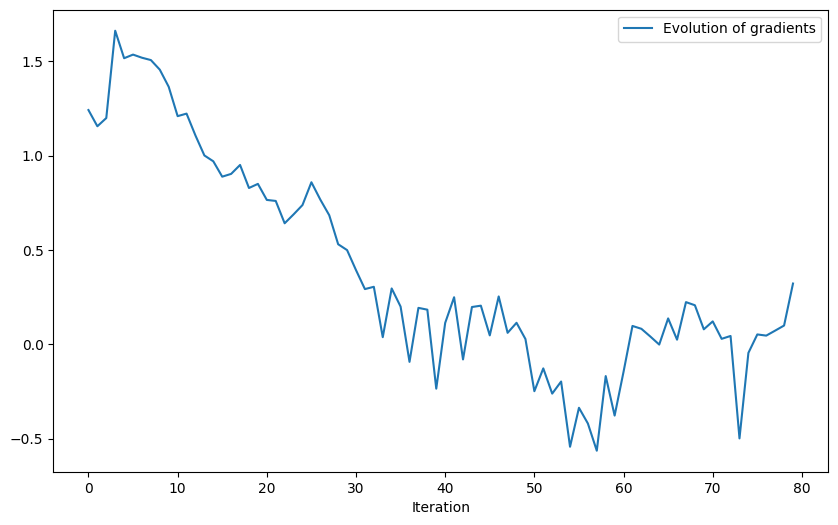

In [11]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [12]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Loss', color='b', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


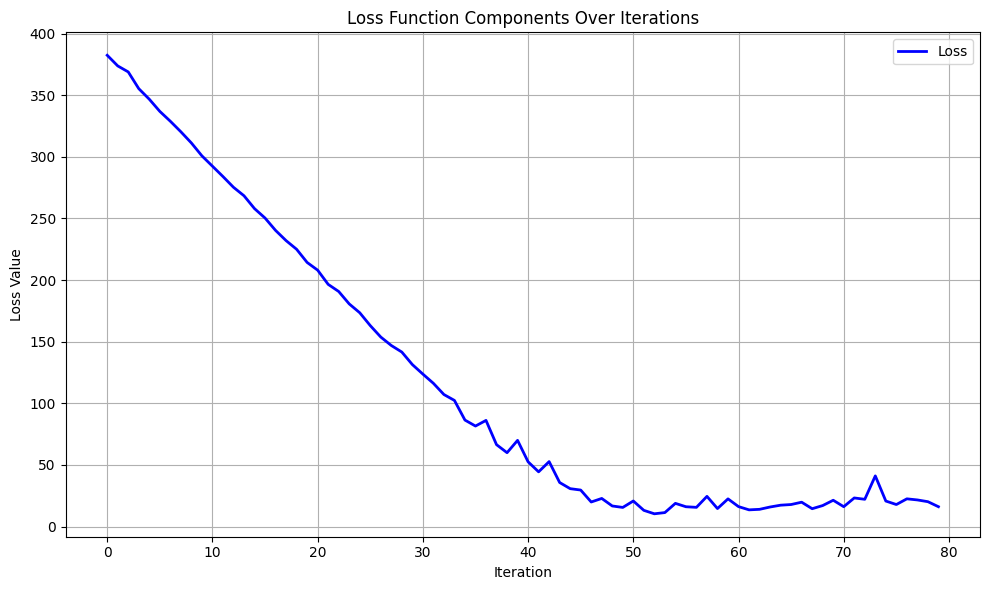

In [13]:
# After the optimization loop
plot_loss_components(total_loss_history)
